# Hajbi et al.

### define process data function

In [1]:
def compare_brine_concentrations(dataframe, raw_data, export_path, literature_cf, original_concentrations = True):
    from chempy.properties.water_density_tanaka_2001 import water_density
    from sigfig import round
    from scipy.constants import milli, kilo
    from chemicals import periodic_table
    from matplotlib import pyplot
    import matplotlib

    pandas.set_option('display.max_columns', None)
    pandas.set_option('display.max_rows', None)
    print('raw_data')
    display(raw_data)
    print('processed_data')
    display(dataframe)

    
    # final effluent concentrations
    final_cf = raw_data['mass_H2O'].iloc[0] / raw_data['mass_H2O'].iloc[-1]
    last_row = dataframe.iloc[-1]
    print('literature_cf', literature_cf)
    print('final_cf', final_cf)

    # feed concentrations
    water_density = water_density()/kilo
    custom_water_parameters = {
        'element': {
            'Ca': {
                'concentration (ppm)':720,
                'reference': ''
            },
            'Mg': {
                'concentration (ppm)':335,
                'reference':''
            },
            'Na': {
                'concentration (ppm)':1950,
                'reference':''
            },
            'Sr': {
                'concentration (ppm)':13,
                'reference':''
            },
            'Cl': {
                'concentration (ppm)':3550,
                'reference':''
            },
            'S(6)': {
                'concentration (ppm)':2250,
                'reference':''
            },
            'Fe': {
                'concentration (ppm)':0.2,
                'reference':''
            }
        }
    }


    elemental_masses = {}
    for element in periodic_table:
        elemental_masses[element.symbol] = element.MW
    
    def make_molal(elements):
        molals = {}
        for element in elements:
            original_element = element
            element = re.sub('(?:\(\d\))', '', element)
            mass = elemental_masses[element]/milli
            if type(elements[original_element]) is dict:
                ppm_conc = elements[original_element]['concentration (ppm)']
            else:
                ppm_conc = elements[original_element]
            molal_conc = ppm_conc / water_density / mass
            molals[original_element] = float(molal_conc)
            
        return molals

    molals = make_molal(custom_water_parameters['element'])
    literature_molals = make_molal(literature_final_conc)

    # final effluent CF for each element
    cfs = {}
    diff_list = []
    labels = []
    for element, final_conc in last_row.iteritems():
        element = re.search('([A-Z][a-z]?(?:\(\d\))?(?=\(mol\/kgw\)))', element).group()
        cfs[element] = {}
        initial_conc = molals[element]

        if original_concentrations:
            if element in literature_elemental_cfs:
                cfs[element]['cf'] = float(final_conc) / initial_conc
                diff = ((cfs[element]['cf'] - literature_elemental_cfs[element]) / literature_elemental_cfs[element]) * 100
                labels.append(element)
                diff_list.append(diff)
                cfs[element]['% diff'] = diff
                
        elif not original_concentrations:
            if element in literature_final_conc:
                predicted_conc = initial_conc * literature_cf
                literature_conc = literature_molals[element]
                diff = ((predicted_conc - literature_conc) / literature_conc) * 100
                labels.append(element)
                diff_list.append(diff)
                cfs[element]['% diff'] = diff

    # define a bar graph of CF error 
    print(cfs)
    labels.append('CF')
    total_cf_error = ((final_cf - literature_cf) / literature_cf * 100)
    diff_list.append(total_cf_error)
    min_diff = min(diff_list) - 5
    max_diff = max(diff_list) + 5

    pyplot.rcParams['figure.figsize'] = (12, 9)
    pyplot.rcParams['figure.dpi'] = 100
    figure, ax = pyplot.subplots()
    bar_graph = ax.bar(labels, diff_list)
    ax.axhline(0, color='grey', linewidth=0.8)
    ax.set_ylabel('relative % difference')
    ax.set_ylim(min_diff, max_diff)
    ax.set_xlabel('Element')
    ax.set_title('Elemental difference of ROSSpy from Hajbi et al.')
    diff_list = [round(value, 2, notation = 'sci') for value in diff_list]
    ax.bar_label(bar_graph, diff_list)
    figure.savefig(export_path)

## Execute multiple modules through all_time

In [46]:
from scipy.constants import nano, milli, day, hour
import os

# run the ROSS model
%run ../../../rosspy/core.py
ross = ROSSPkg()

def average(some_list):
    return sum(some_list)/ len(some_list)

# module parameters
quantity_of_modules = 5
module_characteristics = {        
    'permeate_flow_m3_per_day': 1200 / quantity_of_modules,
    'max_feed_flow_m3_per_hour': 1848 / (day/hour),
}

# water parameters
solution_description = 'Hajbi'
water_characteristics = {
    'element': {
        'Ca': {
            'concentration (ppm)':720,
            'reference': ''
        },
        'Mg': {
            'concentration (ppm)':335,
            'reference':''
        },
        'Na': {
            'concentration (ppm)':1950,
            'reference':''
        },
        'Sr': {
            'concentration (ppm)':13,
            'reference':''
        },
        'Cl': {
            'concentration (ppm)':3550,
            'reference':''
        },
        'S(6)': {
            'concentration (ppm)':2250,
            'reference':''
        },
        'Fe': {
            'concentration (ppm)':0.2,
            'reference':''
        }
    }
}

# literature final effluent concentrations 
literature_final_conc = {
    'Ca': 2080,
    'Mg': 770,
    'Na': 5120,
    'Cl': 14170,
    'S(6)': 5920
}
literature_elemental_cfs = {}
for element in literature_final_conc:
    true_element = re.search('([A-Z][a-z]?)', element).group()
    literature_elemental_cfs[element] = literature_final_conc[element]/(water_characteristics['element'][element]['concentration (ppm)'])
literature_cf = average([literature_final_conc[element]/water_characteristics['element'][element]['concentration (ppm)'] for element in literature_final_conc])

# general parameters
database_selection = 'pitzer'
simulation_title = 'test'
simulation = 'brine'
simulation_perspective = 'all_time'
simulation_time = 75
simulation_name = 'multiple_modules'

# create the input file
ross.define_general(database_selection, simulation, quantity_of_modules = quantity_of_modules)
ross.transport(simulation_time, simulation_perspective, module_characteristics, )
ross.reaction(literature_cf)
ross.solutions(water_characteristics = water_characteristics, solution_description = solution_description)
ross.equilibrium_phases()
ross.selected_output()
ross.export(simulation_name)

# execute and process the input file
raw_data1 = ross.execute()
multi_module_data = ross.process_selected_output()

# process and export the data
export_path = os.path.join(ross.simulation_path, 'Hajbi_comparison.png')
compare_brine_concentrations(multi_module_data, raw_data1, export_path, literature_cf)

1.0314523259470074
cf per cell:  1.0314523259470074
to be 57.089707714297106 	last parameter 29.41527900917913 	previous removal 29.41527900917913
1.0629046518940148
cf per cell:  1.0629046518940148
to be 83.1733846452587 	last parameter 27.674428705117975 	previous removal 57.089707714297106
1.0943569778410225
cf per cell:  1.0943569778410225
to be 107.79963480604033 	last parameter 26.083676930961587 	previous removal 83.1733846452587
1.12580930378803
cf per cell:  1.12580930378803
to be 131.08728904865131 	last parameter 24.626250160781638 	previous removal 107.79963480604033
1.1572616297350373
cf per cell:  1.1572616297350373
to be 153.14260158570949 	last parameter 23.287654242610984 	previous removal 131.08728904865131
1.1887139556820447
cf per cell:  1.1887139556820447
to be 174.0608709357482 	last parameter 22.05531253705817 	previous removal 153.14260158570949
1.2201662816290524
cf per cell:  1.2201662816290524
to be 193.92781646899107 	last parameter 20.918269350038713 	previ

com_error: (-2147352567, 'Exception occurred.', (0, 'IPhreeqcCOM.Object.4', 'ERROR:                   Mu Ionic strength has not converged. \tResidual: -7.827918e-009\n\nERROR:                   pH Charge balance has not converged. \tResidual: -1.775220e-009\n\nERROR:               Oxygen Mass of oxygen has not converged. \tResidual: -9.077488e+000\n\nERROR: Numerical method failed on all combinations of convergence parameters, cell/soln/mix 38\n', None, 0, -2147352567), None)

# Execute multiple modules through all_time, with improvements

In [ ]:
from scipy.constants import nano, milli, day, hour
import os

# run the ROSS model
%run ../../../rosspy/core.py
ross = ROSSPkg()

def average(some_list):
    return sum(some_list)/ len(some_list)

# module parameters
quantity_of_modules = 5
module_characteristics = {        
    'permeate_flow_m3_per_day': 1200 / quantity_of_modules,
    'max_feed_flow_m3_per_hour': 1848 / (day/hour),
}

# water parameters
solution_description = 'Hajbi'
custom_water_parameters = {
    'element': {
        'Ca': {
            'concentration (ppm)':720,
            'reference': ''
        },
        'Mg': {
            'concentration (ppm)':335,
            'reference':''
        },
        'Na': {
            'concentration (ppm)':1950,
            'reference':''
        },
        'Sr': {
            'concentration (ppm)':13,
            'reference':''
        },
        'Cl': {
            'concentration (ppm)':3550,
            'reference':''
        },
        'S(6)': {
            'concentration (ppm)':2250,
            'reference':''
        },
        'Fe': {
            'concentration (ppm)':0.2,
            'reference':''
        }
    }
}

# literature final effluent concentrations 
literature_final_conc = {
    'Ca': 2080,
    'Mg': 770,
    'Na': 5120,
    'Cl': 14170,
    'S(6)': 5920
}
literature_elemental_cfs = {}
for element in literature_final_conc:
    true_element = re.search('([A-Z][a-z]?)', element).group()
    literature_elemental_cfs[element] = literature_final_conc[element]/(custom_water_parameters['element'][element]['concentration (ppm)'])
literature_cf = average([literature_final_conc[element]/custom_water_parameters['element'][element]['concentration (ppm)'] for element in literature_final_conc])

# general parameters
database_selection = 'pitzer'
simulation_title = 'test'
simulation = 'brine'
simulation_perspective = 'all_time'
simulation_time = 175
simulation_name = 'improved_multiple_modules'

# create the input file
ross.define_general(database_selection, simulation, quantity_of_modules = quantity_of_modules)
ross.transport(simulation_time, simulation_perspective, module_characteristics, )
ross.reaction(literature_cf)
ross.solutions(water_characteristics = water_characteristics, solution_description = solution_description)
ross.equilibrium_phases()
ross.selected_output()
ross.export(simulation_name)

# execute and process the input file
raw_data1 = ross.execute()
multi_module_data = ross.process_selected_output()

# process and export the data
export_path = os.path.join(ross.simulation_path, 'Hajbi_comparison.png')
compare_brine_concentrations(multi_module_data, raw_data1, export_path, literature_cf, False)

## Execute a single module over all_time





Estimated completion in 3.20E1 seconds by 2022-01-02 00:36:57.373695 local time.


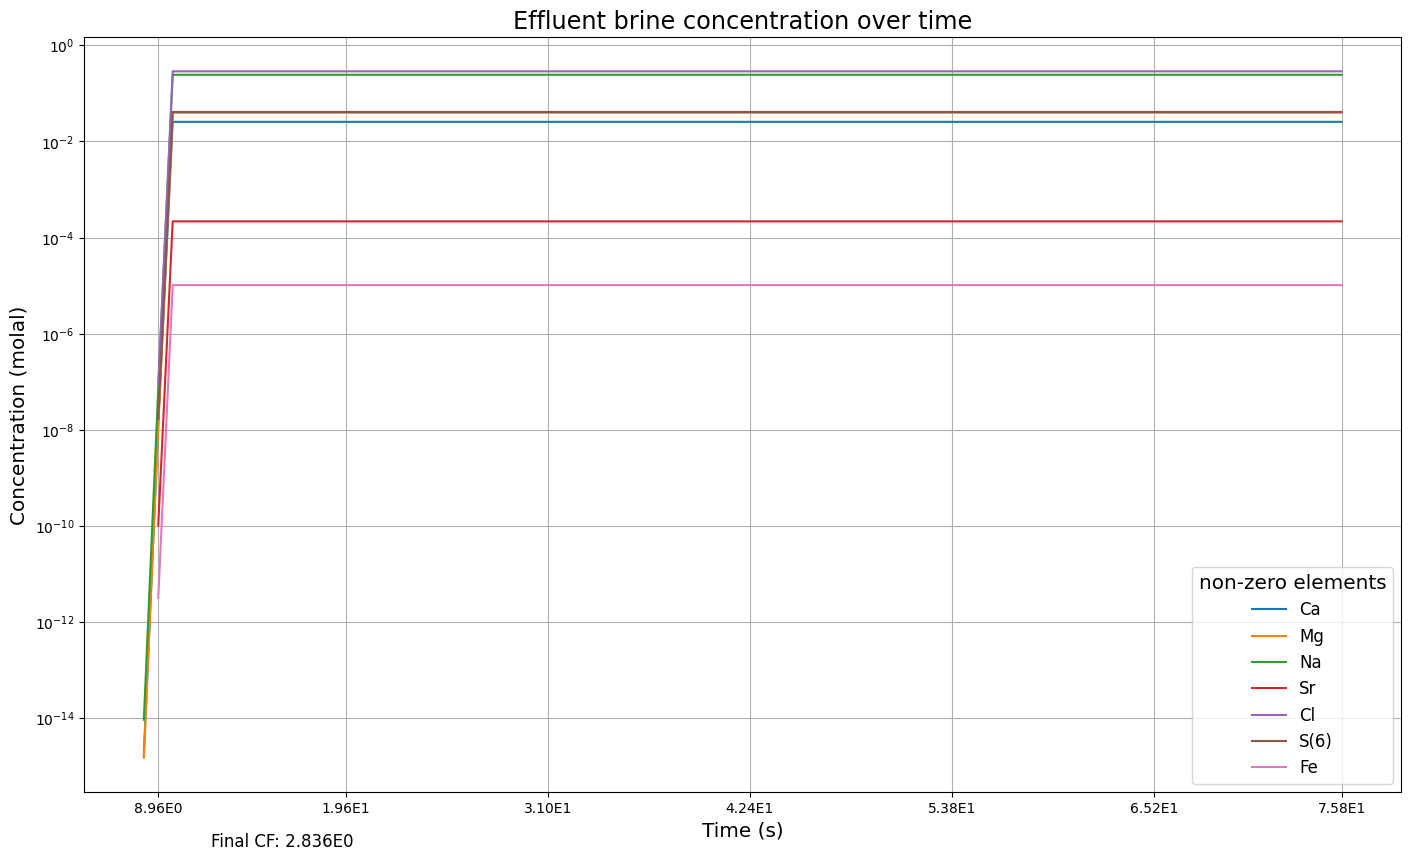

raw_data


sim   state  soln    dist_x        time  step        pH   pe  reaction  \
3      1  transp    60  5.037667    0.000000     0  7.000000  4.0  1.655597   
4      1  transp    60  5.037667    0.814891     1  7.000005  4.0  1.655597   
5      1  transp    60  5.037667    1.629783     2  7.000009  4.0  1.655597   
6      1  transp    60  5.037667    2.444674     3  7.000014  4.0  1.655597   
7      1  transp    60  5.037667    3.259566     4  7.000018  4.0  1.655597   
8      1  transp    60  5.037667    4.074457     5  7.000023  4.0  1.655597   
9      1  transp    60  5.037667    4.889349     6  7.000028  4.0  1.655597   
10     1  transp    60  5.037667    5.704240     7  7.000033  4.0  1.655597   
11     1  transp    60  5.037667    6.519132     8  7.000038  4.0  1.655597   
12     1  transp    60  5.037667    7.334023     9  7.000043  4.0  1.655597   
13     1  transp    60  5.037667    8.148915    10  7.000048  4.0  1.655597   
14     1  transp    60  5.037667    8.963806    11  7.000053  4.0  1.655597   
15     1  transp    60  5.037667    9.778697    12  7.000058  4.0  1.655597   
16     1  transp    60  5.037667   10.593589    13  7.000063  4.0  1.655597   
17     1  transp    60  5.037667   11.408480    14  7.000068  4.0  1.655597   
18     1  transp    60  5.037667   12.223372    15  7.000073  4.0  1.655597   
19     1  transp    60  5.037667   13.038263    16  7.000078  4.0  1.655597   
20     1  transp    60  5.037667   13.853155    17  7.000083  4.0  1.655597   
21     1  transp    60  5.037667   14.668046    18  7.000088  4.0  1.655597   
22     1  transp    60  5.037667   15.482938    19  7.000093  4.0  1.655597   
23     1  transp    60  5.037667   16.297829    20  7.000098  4.0  1.655597   
24     1  transp    60  5.037667   17.112721    21  7.000103  4.0  1.655597   
25     1  transp    60  5.037667   17.927612    22  7.000109  4.0  1.655597   
26     1  transp    60  5.037667   18.742504    23  7.000114  4.0  1.655597   
27     1  transp    60  5.037667   19.557395    24  7.000119  4.0  1.655597   
28     1  transp    60  5.037667   20.372286    25  7.000124  4.0  1.655597   
29     1  transp    60  5.037667   21.187178    26  7.000129  4.0  1.655597   
30     1  transp    60  5.037667   22.002069    27  7.000134  4.0  1.655597   
31     1  transp    60  5.037667   22.816961    28  7.000140  4.0  1.655597   
32     1  transp    60  5.037667   23.631852    29  7.000145  4.0  1.655597   
33     1  transp    60  5.037667   24.446744    30  7.000150  4.0  1.655597   
34     1  transp    60  5.037667   25.261635    31  7.000155  4.0  1.655597   
35     1  transp    60  5.037667   26.076527    32  7.000161  4.0  1.655597   
36     1  transp    60  5.037667   26.891418    33  7.000166  4.0  1.655597   
37     1  transp    60  5.037667   27.706310    34  7.000172  4.0  1.655597   
38     1  transp    60  5.037667   28.521201    35  7.000178  4.0  1.655597   
39     1  transp    60  5.037667   29.336092    36  7.000183  4.0  1.655597   
40     1  transp    60  5.037667   30.150984    37  7.000188  4.0  1.655597   
41     1  transp    60  5.037667   30.965875    38  7.000194  4.0  1.655597   
42     1  transp    60  5.037667   31.780767    39  7.000199  4.0  1.655597   
43     1  transp    60  5.037667   32.595658    40  7.000204  4.0  1.655597   
44     1  transp    60  5.037667   33.410550    41  7.000210  4.0  1.655597   
45     1  transp    60  5.037667   34.225441    42  7.000215  4.0  1.655597   
46     1  transp    60  5.037667   35.040333    43  7.000221  4.0  1.655597   
47     1  transp    60  5.037667   35.855224    44  7.000227  4.0  1.655597   
48     1  transp    60  5.037667   36.670116    45  7.000232  4.0  1.655597   
49     1  transp    60  5.037667   37.485007    46  7.000238  4.0  1.655597   
50     1  transp    60  5.037667   38.299899    47  7.000244  4.0  1.655597   
51     1  transp    60  5.037667   39.114790    48  7.000250  4.0  1.655597   
52     1  transp    60  5.037667   39.929681    49  7.0

processed_data


Ca(mol/kgw) Mg(mol/kgw) Na(mol/kgw) Sr(mol/kgw) Cl(mol/kgw)  \
Time (s)                                                               
4.73E1     3.995E-14   3.065E-14   1.886E-13   3.300E-16   2.227E-13   
4.81E1      4.118E-8    3.159E-8    1.944E-7   3.401E-10    2.295E-7   
4.89E1      2.032E-2    1.559E-2    9.596E-2    1.678E-4    1.133E-1   
4.97E1      2.032E-2    1.559E-2    9.596E-2    1.678E-4    1.133E-1   
5.05E1      2.032E-2    1.559E-2    9.596E-2    1.678E-4    1.133E-1   
5.13E1      2.032E-2    1.559E-2    9.596E-2    1.678E-4    1.133E-1   
5.22E1      2.032E-2    1.559E-2    9.596E-2    1.678E-4    1.133E-1   
5.30E1      2.032E-2    1.559E-2    9.596E-2    1.678E-4    1.133E-1   
5.38E1      2.032E-2    1.559E-2    9.596E-2    1.678E-4    1.133E-1   
5.46E1      2.032E-2    1.559E-2    9.596E-2    1.678E-4    1.133E-1   
5.54E1      2.032E-2    1.559E-2    9.596E-2    1.678E-4    1.133E-1   
5.62E1      2.032E-2    1.559E-2    9.596E-2    1.678E-4    1.133E-1   
5.70E1      2.032E-2    1.559E-2    9.596E-2    1.678E-4    1.133E-1   
5.79E1      2.032E-2    1.559E-2    9.596E-2    1.678E-4    1.133E-1   
5.87E1      2.032E-2    1.559E-2    9.596E-2    1.678E-4    1.133E-1   
5.95E1      2.032E-2    1.559E-2    9.596E-2    1.678E-4    1.133E-1   
6.03E1      2.032E-2    1.559E-2    9.596E-2    1.678E-4    1.133E-1   
6.11E1      2.032E-2    1.559E-2    9.596E-2    1.678E-4    1.133E-1   
6.19E1      2.032E-2    1.559E-2    9.596E-2    1.678E-4    1.133E-1   
6.27E1      2.032E-2    1.559E-2    9.596E-2    1.678E-4    1.133E-1   
6.36E1      2.032E-2    1.559E-2    9.596E-2    1.678E-4    1.133E-1   
6.44E1      2.032E-2    1.559E-2    9.596E-2    1.678E-4    1.133E-1   
6.52E1      2.032E-2    1.559E-2    9.596E-2    1.678E-4    1.133E-1   
6.60E1      2.032E-2    1.559E-2    9.596E-2    1.678E-4    1.133E-1   
6.68E1      2.032E-2    1.559E-2    9.596E-2    1.678E-4    1.133E-1   
6.76E1      2.032E-2    1.559E-2    9.596E-2    1.678E-4    1.133E-1   
6.85E1      2.032E-2    1.559E-2    9.596E-2    1.678E-4    1.133E-1   
6.93E1      2.032E-2    1.559E-2    9.596E-2    1.678E-4    1.133E-1   
7.01E1      2.032E-2    1.559E-2    9.596E-2    1.678E-4    1.133E-1   
7.09E1      2.032E-2    1.559E-2    9.596E-2    1.678E-4    1.133E-1   
7.17E1      2.032E-2    1.559E-2    9.596E-2    1.678E-4    1.133E-1   
7.25E1      2.032E-2    1.559E-2    9.596E-2    1.678E-4    1.133E-1   
7.33E1      2.032E-2    1.559E-2    9.596E-2    1.678E-4    1.133E-1   
7.42E1      2.032E-2    1.559E-2    9.596E-2    1.678E-4    1.133E-1   
7.50E1      2.032E-2    1.559E-2    9.596E-2    1.678E-4    1.133E-1   
7.58E1      2.032E-2    1.559E-2    9.596E-2    1.678E-4    1.133E-1   
7.66E1      2.032E-2    1.559E-2    9.596E-2    1.678E-4    1.133E-1   
7.74E1      2.032E-2    1.559E-2    9.596E-2    1.678E-4    1.133E-1   
7.82E1      2.032E-2    1.559E-2    9.596E-2    1.678E-4    1.133E-1   
7.90E1      2.032E-2    1.559E-2    9.596E-2    1.678E-4    1.133E-1   
7.99E1      2.032E-2    1.559E-2    9.596E-2    1.678E-4    1.133E-1   
8.07E1      2.032E-2    1.559E-2    9.596E-2    1.678E-4    1.133E-1   
8.15E1      2.032E-2    1.559E-2    9.596E-2    1.678E-4    1.133E-1   
8.23E1      2.032E-2    1.559E-2    9.596E-2    1.678E-4    1.133E-1   
8.31E1      2.032E-2    1.559E-2    9.596E-2    1.678E-4    1.133E-1   
8.39E1      2.032E-2    1.559E-2    9.596E-2    1.678E-4    1.133E-1   
8.47E1      2.032E-2    1.559E-2    9.596E-2    1.678E-4    1.133E-1   
8.56E1      2.032E-2    1.559E-2    9.596E-2    1.678E-4    1.133E-1   
8.64E1      2.032E-2    1.559E-2    9.596E-2    1.678E-4    1.133E-1   
8.72E1      2.032E-2    1.559E-2    9.596E-2    1.678E-4    1.133E-1   
8.80E1      2.032E-2    1.559E-2    9.596E-2    1.678E-4    1.133E-1   
8.88E1      2.032E-2    1.559E-2    9.596E-2    1.678E-4    1.133E-1   
8.96E1      2.032E-2    1.559E-2    9.596E-2    1.678E-4    1.133E-1   
9.05E1      2.032E-2    1.559E-2    9.596E-2    1

literature_cf 2.8871395568204483
final_cf 1.1213074395816869
{'Ca': {'% diff': -0.060553802369103446}, 'Mg': {'% diff': 25.60931838114937}, 'Na': {'% diff': 9.959416714841304}, 'Sr': {}, 'Cl': {'% diff': -27.668698470623927}, 'S(6)': {'% diff': 9.73081085888527}, 'Fe': {}}


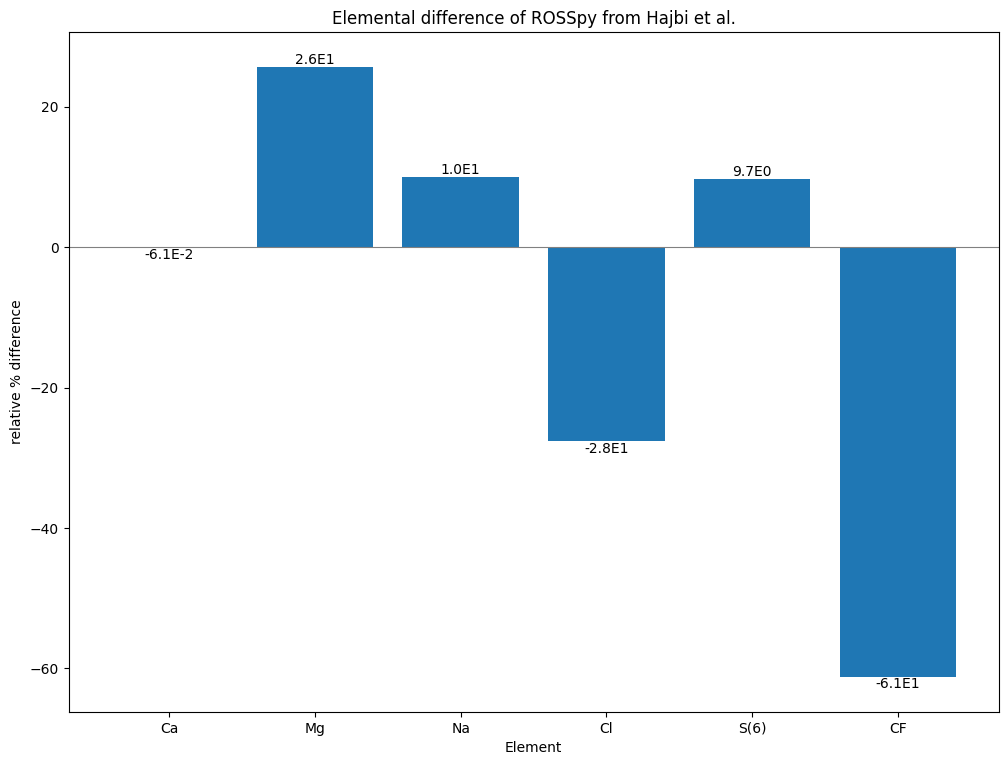

In [9]:
from scipy.constants import nano, milli, day, hour

# run the ROSS model
%run ../../../rosspy/core.py
ross = ROSSPkg()

def average(some_list):
    return sum(some_list)/ len(some_list)

# module parameters
quantity_of_modules = 1
module_characteristics = {        
    'permeate_flow_m3_per_day': 1200 / quantity_of_modules,
    'max_feed_flow_m3_per_hour': 1848 / (day/hour),
}

# water parameters
solution_description = 'Hajbi'
custom_water_parameters = {
    'element': {
        'Ca': {
            'concentration (ppm)':720,
            'reference': ''
        },
        'Mg': {
            'concentration (ppm)':335,
            'reference':''
        },
        'Na': {
            'concentration (ppm)':1950,
            'reference':''
        },
        'Sr': {
            'concentration (ppm)':13,
            'reference':''
        },
        'Cl': {
            'concentration (ppm)':3550,
            'reference':''
        },
        'S(6)': {
            'concentration (ppm)':2250,
            'reference':''
        },
        'Fe': {
            'concentration (ppm)':0.2,
            'reference':''
        }
    }
}

# general parameters
database_selection = 'pitzer'
simulation_title = 'test'
simulation = 'brine'
simulation_perspective = 'all_time'
simulation_time = 75
simulation_name = 'improved_single_module'

# create the input file
ross.define_general(database_selection, simulation, quantity_of_modules = quantity_of_modules)
ross.transport(simulation_time, simulation_perspective, module_characteristics, )
ross.reaction(literature_cf)
ross.solutions(water_characteristics = water_characteristics, solution_description = solution_description)
ross.equilibrium_phases()
ross.selected_output()
ross.export(simulation_name)

# execute the input file
raw_data2 = ross.execute()
single_module_data1 = ross.process_selected_output()

# process and export the data
export_path = os.path.join(ross.simulation_path, 'Hajbi_comparison.png')
compare_brine_concentrations(multi_module_data, raw_data1, export_path, literature_cf, False)

## Execute a single module over all_distance





Estimated completion in 3.20E1 seconds by 2022-01-02 00:37:05.793896 local time.


C:\Users\Andrew Freiburger\AppData\Roaming\Python\Python37\site-packages\sigfig\sigfig.py:572: UserWarning: warning: 3 significant figures requested from number with only 2 significant figures
  warn("warning: %d significant figures requested from number with only %d significant figures" % (given['sigfigs'], len(num.map)))


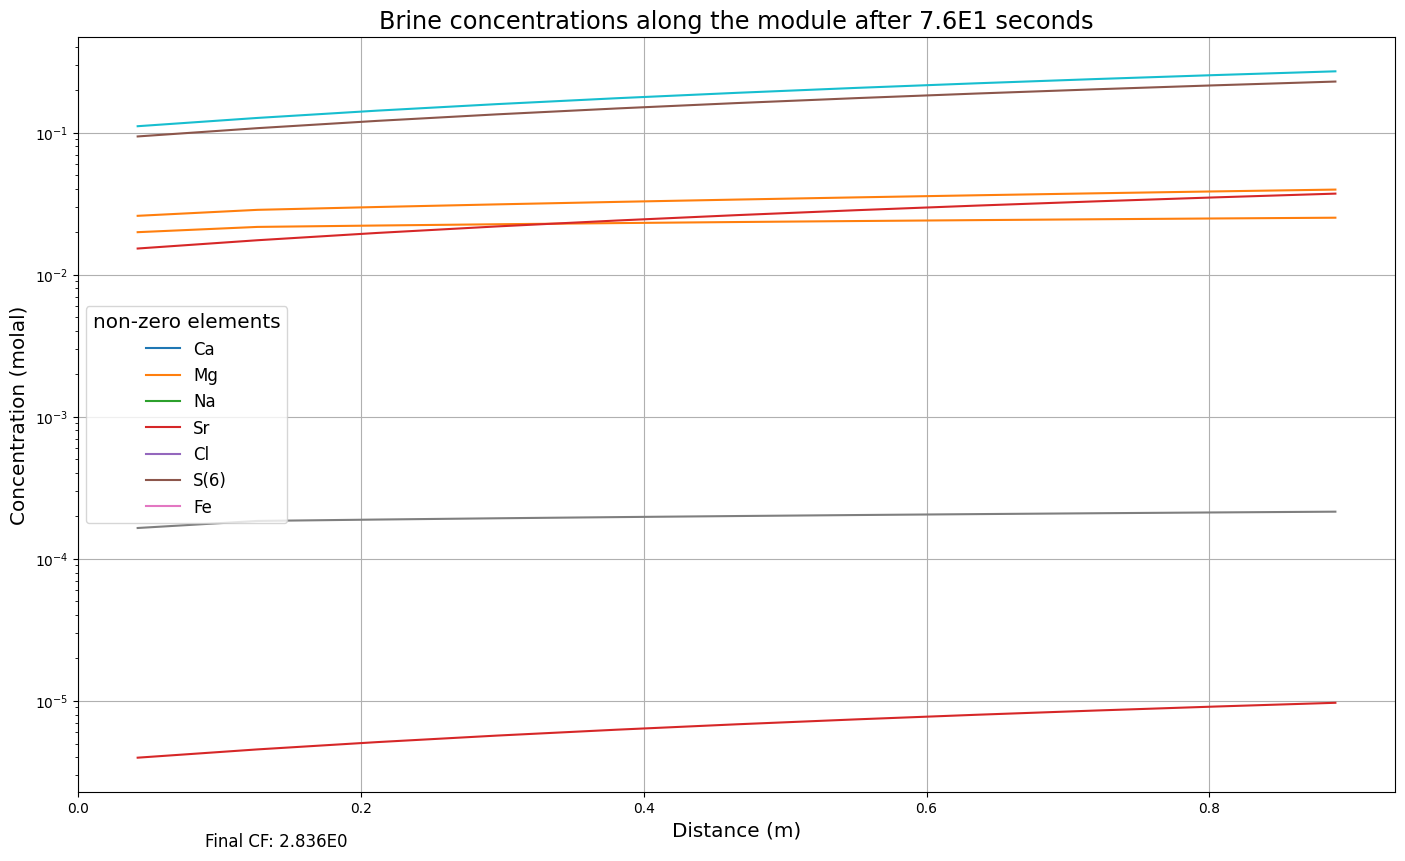

raw_data


sim   state  soln    dist_x        time  step        pH   pe  reaction  \
3      1  transp    60  5.037667    0.000000     0  7.000000  4.0  1.655597   
4      1  transp    60  5.037667    0.814891     1  7.000005  4.0  1.655597   
5      1  transp    60  5.037667    1.629783     2  7.000009  4.0  1.655597   
6      1  transp    60  5.037667    2.444674     3  7.000014  4.0  1.655597   
7      1  transp    60  5.037667    3.259566     4  7.000018  4.0  1.655597   
8      1  transp    60  5.037667    4.074457     5  7.000023  4.0  1.655597   
9      1  transp    60  5.037667    4.889349     6  7.000028  4.0  1.655597   
10     1  transp    60  5.037667    5.704240     7  7.000033  4.0  1.655597   
11     1  transp    60  5.037667    6.519132     8  7.000038  4.0  1.655597   
12     1  transp    60  5.037667    7.334023     9  7.000043  4.0  1.655597   
13     1  transp    60  5.037667    8.148915    10  7.000048  4.0  1.655597   
14     1  transp    60  5.037667    8.963806    11  7.000053  4.0  1.655597   
15     1  transp    60  5.037667    9.778697    12  7.000058  4.0  1.655597   
16     1  transp    60  5.037667   10.593589    13  7.000063  4.0  1.655597   
17     1  transp    60  5.037667   11.408480    14  7.000068  4.0  1.655597   
18     1  transp    60  5.037667   12.223372    15  7.000073  4.0  1.655597   
19     1  transp    60  5.037667   13.038263    16  7.000078  4.0  1.655597   
20     1  transp    60  5.037667   13.853155    17  7.000083  4.0  1.655597   
21     1  transp    60  5.037667   14.668046    18  7.000088  4.0  1.655597   
22     1  transp    60  5.037667   15.482938    19  7.000093  4.0  1.655597   
23     1  transp    60  5.037667   16.297829    20  7.000098  4.0  1.655597   
24     1  transp    60  5.037667   17.112721    21  7.000103  4.0  1.655597   
25     1  transp    60  5.037667   17.927612    22  7.000109  4.0  1.655597   
26     1  transp    60  5.037667   18.742504    23  7.000114  4.0  1.655597   
27     1  transp    60  5.037667   19.557395    24  7.000119  4.0  1.655597   
28     1  transp    60  5.037667   20.372286    25  7.000124  4.0  1.655597   
29     1  transp    60  5.037667   21.187178    26  7.000129  4.0  1.655597   
30     1  transp    60  5.037667   22.002069    27  7.000134  4.0  1.655597   
31     1  transp    60  5.037667   22.816961    28  7.000140  4.0  1.655597   
32     1  transp    60  5.037667   23.631852    29  7.000145  4.0  1.655597   
33     1  transp    60  5.037667   24.446744    30  7.000150  4.0  1.655597   
34     1  transp    60  5.037667   25.261635    31  7.000155  4.0  1.655597   
35     1  transp    60  5.037667   26.076527    32  7.000161  4.0  1.655597   
36     1  transp    60  5.037667   26.891418    33  7.000166  4.0  1.655597   
37     1  transp    60  5.037667   27.706310    34  7.000172  4.0  1.655597   
38     1  transp    60  5.037667   28.521201    35  7.000178  4.0  1.655597   
39     1  transp    60  5.037667   29.336092    36  7.000183  4.0  1.655597   
40     1  transp    60  5.037667   30.150984    37  7.000188  4.0  1.655597   
41     1  transp    60  5.037667   30.965875    38  7.000194  4.0  1.655597   
42     1  transp    60  5.037667   31.780767    39  7.000199  4.0  1.655597   
43     1  transp    60  5.037667   32.595658    40  7.000204  4.0  1.655597   
44     1  transp    60  5.037667   33.410550    41  7.000210  4.0  1.655597   
45     1  transp    60  5.037667   34.225441    42  7.000215  4.0  1.655597   
46     1  transp    60  5.037667   35.040333    43  7.000221  4.0  1.655597   
47     1  transp    60  5.037667   35.855224    44  7.000227  4.0  1.655597   
48     1  transp    60  5.037667   36.670116    45  7.000232  4.0  1.655597   
49     1  transp    60  5.037667   37.485007    46  7.000238  4.0  1.655597   
50     1  transp    60  5.037667   38.299899    47  7.000244  4.0  1.655597   
51     1  transp    60  5.037667   39.114790    48  7.000250  4.0  1.655597   
52     1  transp    60  5.037667   39.929681    49  7.0

processed_data


Ca(mol/kgw) Mg(mol/kgw) Na(mol/kgw) Sr(mol/kgw) Cl(mol/kgw)  \
Time (s)                                                               
4.73E1     3.995E-14   3.065E-14   1.886E-13   3.300E-16   2.227E-13   
4.81E1      4.118E-8    3.159E-8    1.944E-7   3.401E-10    2.295E-7   
4.89E1      2.032E-2    1.559E-2    9.596E-2    1.678E-4    1.133E-1   
4.97E1      2.032E-2    1.559E-2    9.596E-2    1.678E-4    1.133E-1   
5.05E1      2.032E-2    1.559E-2    9.596E-2    1.678E-4    1.133E-1   
5.13E1      2.032E-2    1.559E-2    9.596E-2    1.678E-4    1.133E-1   
5.22E1      2.032E-2    1.559E-2    9.596E-2    1.678E-4    1.133E-1   
5.30E1      2.032E-2    1.559E-2    9.596E-2    1.678E-4    1.133E-1   
5.38E1      2.032E-2    1.559E-2    9.596E-2    1.678E-4    1.133E-1   
5.46E1      2.032E-2    1.559E-2    9.596E-2    1.678E-4    1.133E-1   
5.54E1      2.032E-2    1.559E-2    9.596E-2    1.678E-4    1.133E-1   
5.62E1      2.032E-2    1.559E-2    9.596E-2    1.678E-4    1.133E-1   
5.70E1      2.032E-2    1.559E-2    9.596E-2    1.678E-4    1.133E-1   
5.79E1      2.032E-2    1.559E-2    9.596E-2    1.678E-4    1.133E-1   
5.87E1      2.032E-2    1.559E-2    9.596E-2    1.678E-4    1.133E-1   
5.95E1      2.032E-2    1.559E-2    9.596E-2    1.678E-4    1.133E-1   
6.03E1      2.032E-2    1.559E-2    9.596E-2    1.678E-4    1.133E-1   
6.11E1      2.032E-2    1.559E-2    9.596E-2    1.678E-4    1.133E-1   
6.19E1      2.032E-2    1.559E-2    9.596E-2    1.678E-4    1.133E-1   
6.27E1      2.032E-2    1.559E-2    9.596E-2    1.678E-4    1.133E-1   
6.36E1      2.032E-2    1.559E-2    9.596E-2    1.678E-4    1.133E-1   
6.44E1      2.032E-2    1.559E-2    9.596E-2    1.678E-4    1.133E-1   
6.52E1      2.032E-2    1.559E-2    9.596E-2    1.678E-4    1.133E-1   
6.60E1      2.032E-2    1.559E-2    9.596E-2    1.678E-4    1.133E-1   
6.68E1      2.032E-2    1.559E-2    9.596E-2    1.678E-4    1.133E-1   
6.76E1      2.032E-2    1.559E-2    9.596E-2    1.678E-4    1.133E-1   
6.85E1      2.032E-2    1.559E-2    9.596E-2    1.678E-4    1.133E-1   
6.93E1      2.032E-2    1.559E-2    9.596E-2    1.678E-4    1.133E-1   
7.01E1      2.032E-2    1.559E-2    9.596E-2    1.678E-4    1.133E-1   
7.09E1      2.032E-2    1.559E-2    9.596E-2    1.678E-4    1.133E-1   
7.17E1      2.032E-2    1.559E-2    9.596E-2    1.678E-4    1.133E-1   
7.25E1      2.032E-2    1.559E-2    9.596E-2    1.678E-4    1.133E-1   
7.33E1      2.032E-2    1.559E-2    9.596E-2    1.678E-4    1.133E-1   
7.42E1      2.032E-2    1.559E-2    9.596E-2    1.678E-4    1.133E-1   
7.50E1      2.032E-2    1.559E-2    9.596E-2    1.678E-4    1.133E-1   
7.58E1      2.032E-2    1.559E-2    9.596E-2    1.678E-4    1.133E-1   
7.66E1      2.032E-2    1.559E-2    9.596E-2    1.678E-4    1.133E-1   
7.74E1      2.032E-2    1.559E-2    9.596E-2    1.678E-4    1.133E-1   
7.82E1      2.032E-2    1.559E-2    9.596E-2    1.678E-4    1.133E-1   
7.90E1      2.032E-2    1.559E-2    9.596E-2    1.678E-4    1.133E-1   
7.99E1      2.032E-2    1.559E-2    9.596E-2    1.678E-4    1.133E-1   
8.07E1      2.032E-2    1.559E-2    9.596E-2    1.678E-4    1.133E-1   
8.15E1      2.032E-2    1.559E-2    9.596E-2    1.678E-4    1.133E-1   
8.23E1      2.032E-2    1.559E-2    9.596E-2    1.678E-4    1.133E-1   
8.31E1      2.032E-2    1.559E-2    9.596E-2    1.678E-4    1.133E-1   
8.39E1      2.032E-2    1.559E-2    9.596E-2    1.678E-4    1.133E-1   
8.47E1      2.032E-2    1.559E-2    9.596E-2    1.678E-4    1.133E-1   
8.56E1      2.032E-2    1.559E-2    9.596E-2    1.678E-4    1.133E-1   
8.64E1      2.032E-2    1.559E-2    9.596E-2    1.678E-4    1.133E-1   
8.72E1      2.032E-2    1.559E-2    9.596E-2    1.678E-4    1.133E-1   
8.80E1      2.032E-2    1.559E-2    9.596E-2    1.678E-4    1.133E-1   
8.88E1      2.032E-2    1.559E-2    9.596E-2    1.678E-4    1.133E-1   
8.96E1      2.032E-2    1.559E-2    9.596E-2    1.678E-4    1.133E-1   
9.05E1      2.032E-2    1.559E-2    9.596E-2    1

literature_cf 2.8871395568204483
final_cf 1.1213074395816869
{'Ca': {'% diff': -0.060553802369103446}, 'Mg': {'% diff': 25.60931838114937}, 'Na': {'% diff': 9.959416714841304}, 'Sr': {}, 'Cl': {'% diff': -27.668698470623927}, 'S(6)': {'% diff': 9.73081085888527}, 'Fe': {}}


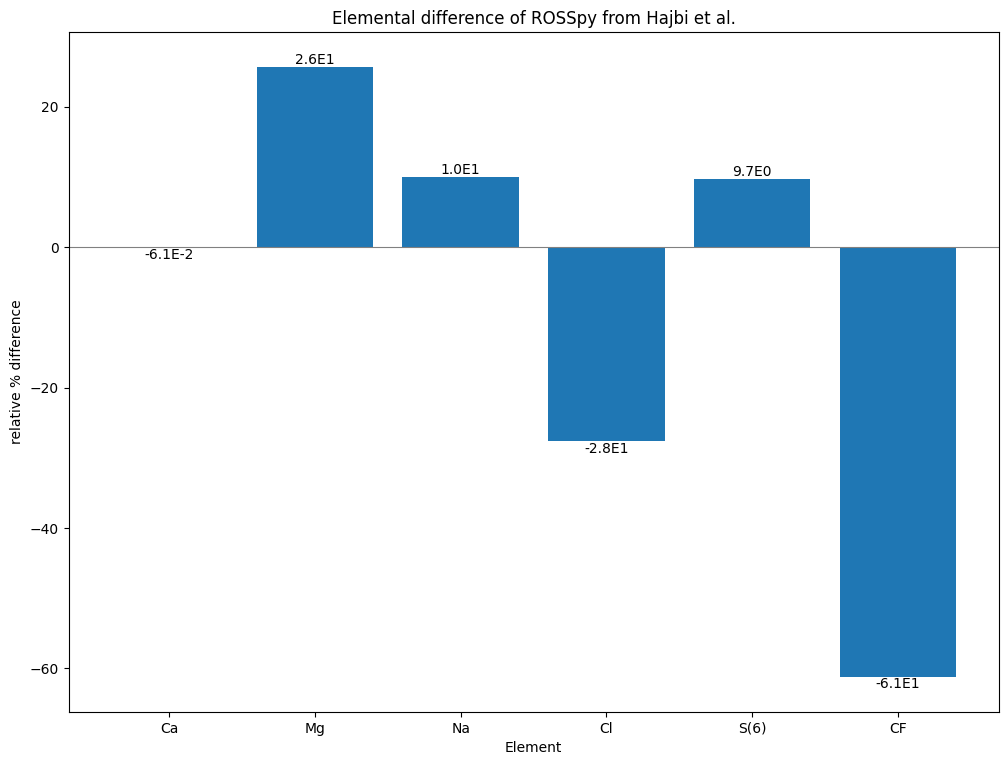

In [10]:
from scipy.constants import nano, milli, day, hour

# run the ROSS model
%run ../../../rosspy/core.py
ross = ROSSPkg()

def average(some_list):
    return sum(some_list)/ len(some_list)

# module parameters
quantity_of_modules = 1
solution_description = 'Hajbi'
module_characteristics = {        
    'permeate_flow_m3_per_day': 1200 / quantity_of_modules,
    'max_feed_flow_m3_per_hour': 1848 / (day/hour),
}

# water parameters
custom_water_parameters = {
    'element': {
        'Ca': {
            'concentration (ppm)':720,
            'reference': ''
        },
        'Mg': {
            'concentration (ppm)':335,
            'reference':''
        },
        'Na': {
            'concentration (ppm)':1950,
            'reference':''
        },
        'Sr': {
            'concentration (ppm)':13,
            'reference':''
        },
        'Cl': {
            'concentration (ppm)':3550,
            'reference':''
        },
        'S(6)': {
            'concentration (ppm)':2250,
            'reference':''
        },
        'Fe': {
            'concentration (ppm)':0.2,
            'reference':''
        }
    }
}

# general parameters
database_selection = 'pitzer'
simulation_title = 'test'
simulation = 'brine'
simulation_perspective = 'all_distance'
simulation_time = 75
simulation_name = 'improved_single_module_over_distance'

# create the input file
ross.define_general(database_selection, simulation, quantity_of_modules = quantity_of_modules)
ross.transport(simulation_time, simulation_perspective, module_characteristics, )
ross.reaction(literature_cf)
ross.solutions(water_characteristics = water_characteristics, solution_description = solution_description)
ross.equilibrium_phases()
ross.selected_output()
ross.export(simulation_name)

# execute the input file
raw_data3 = ross.execute()
single_module_data2 = ross.process_selected_output()

# process and export the data
export_path = os.path.join(ross.simulation_path, 'Hajbi_comparison.png')
compare_brine_concentrations(multi_module_data, raw_data1, export_path, literature_cf, False)